## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

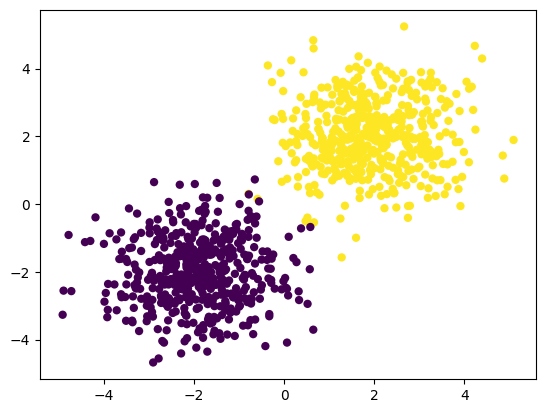

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
'''
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())



print(net)
'''
criterion = ClassNLLCriterion()
# Test something like that then

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

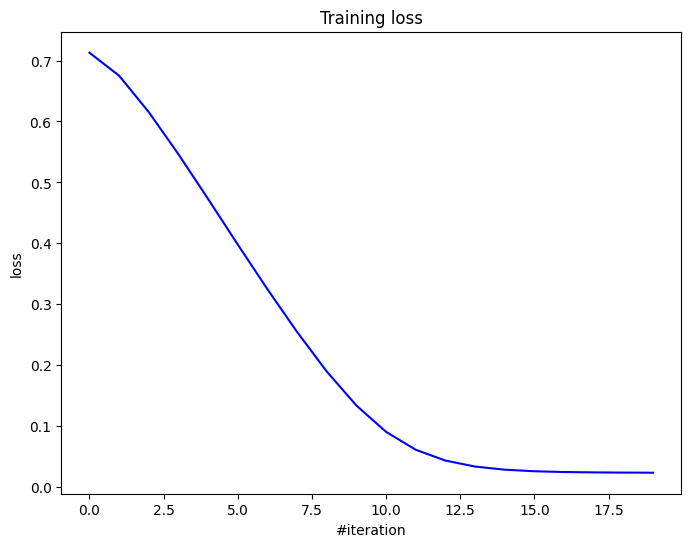

Current loss: 0.023513


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
#!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [ ]:
#import mnist
#X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [ ]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img

    return images, labels


train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

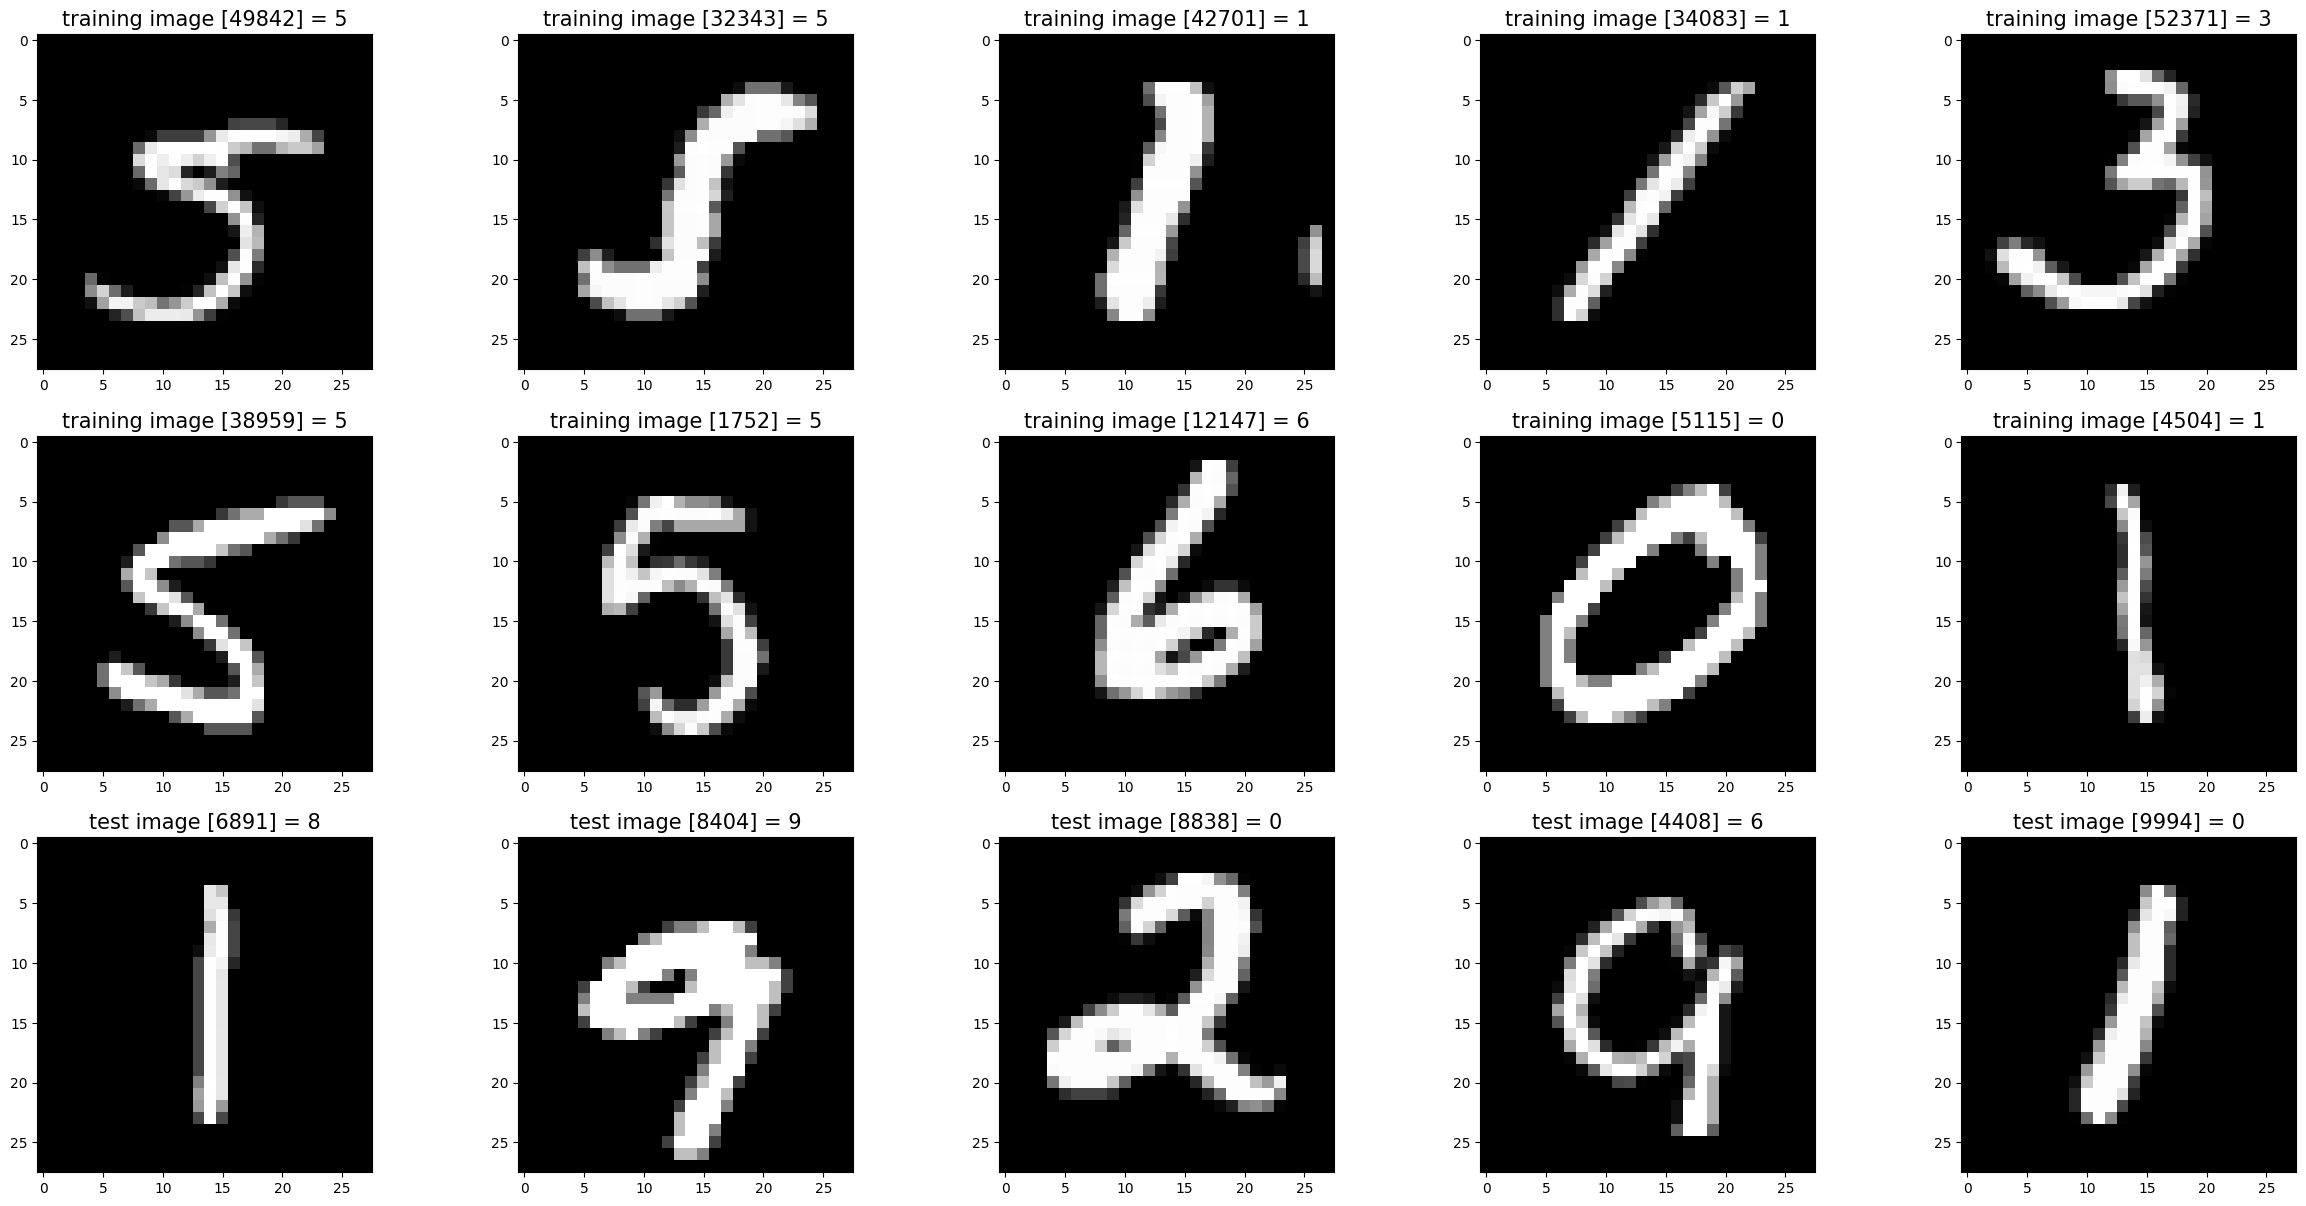

In [ ]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_images[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_images[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(train_labels[r]))

show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

In [ ]:
# Your code goes here. ################################################
# классы от 0 до 9
num_classes = 10

# Создаем one-hot encoding для тренировочных меток
train_labels_one_hot = np.eye(num_classes)[train_labels]

# Создаем one-hot encoding для тестовых меток
test_labels_one_hot = np.eye(num_classes)[test_labels]

print(train_labels[:5])
print(train_labels_one_hot[:5])

print(test_labels[:5])
print(test_labels_one_hot[:5])

array('B', [5, 0, 4, 1, 9])
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
array('B', [7, 2, 1, 0, 4])
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
# Данные: нормализация
train_images = np.array(train_images).reshape(-1, 28 * 28) / 255.0
test_images = np.array(test_images).reshape(-1, 28 * 28) / 255.0

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.


Текущая функция активации: ReLU
Эпоха 1, текущая потеря: 0.5798
Эпоха 2, текущая потеря: 0.4082
Эпоха 3, текущая потеря: 0.3104
Эпоха 4, текущая потеря: 0.3201
Эпоха 5, текущая потеря: 0.3331
Эпоха 6, текущая потеря: 0.3014
Эпоха 7, текущая потеря: 0.2535
Эпоха 8, текущая потеря: 0.2916
Эпоха 9, текущая потеря: 0.2488
Эпоха 10, текущая потеря: 0.2473

Текущая функция активации: ELU
Эпоха 1, текущая потеря: 0.5949
Эпоха 2, текущая потеря: 0.3970
Эпоха 3, текущая потеря: 0.3654
Эпоха 4, текущая потеря: 0.2825
Эпоха 5, текущая потеря: 0.3446
Эпоха 6, текущая потеря: 0.2714
Эпоха 7, текущая потеря: 0.3266
Эпоха 8, текущая потеря: 0.3089
Эпоха 9, текущая потеря: 0.2960
Эпоха 10, текущая потеря: 0.2326

Текущая функция активации: LeakyReLU
Эпоха 1, текущая потеря: 0.5187
Эпоха 2, текущая потеря: 0.3462
Эпоха 3, текущая потеря: 0.3802
Эпоха 4, текущая потеря: 0.3439
Эпоха 5, текущая потеря: 0.3297
Эпоха 6, текущая потеря: 0.3482
Эпоха 7, текущая потеря: 0.3482
Эпоха 8, текущая потеря: 0.2516

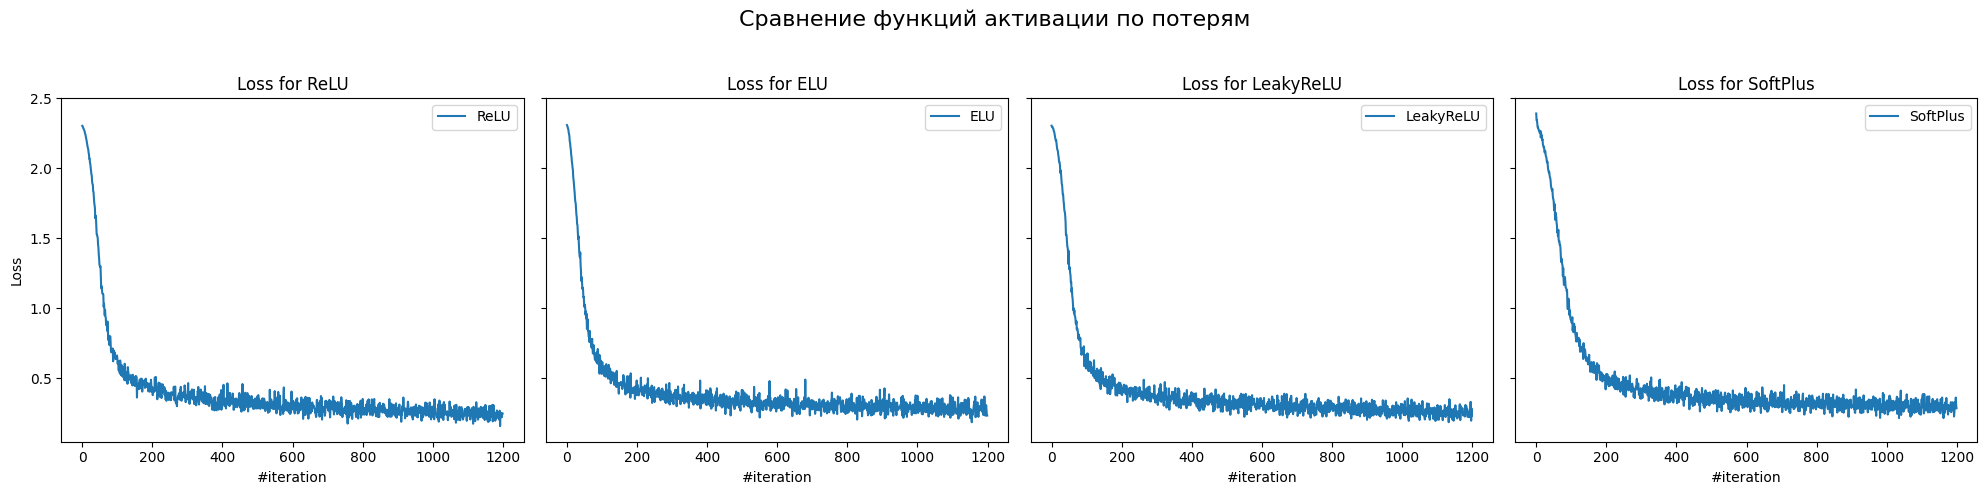

Результаты сравнения моделей:

Функция активации: ReLU
Точность: 0.9328
Время выполнения: 310.18 секунд

Функция активации: ELU
Точность: 0.9232
Время выполнения: 312.89 секунд

Функция активации: LeakyReLU
Точность: 0.9317
Время выполнения: 311.23 секунд

Функция активации: SoftPlus
Точность: 0.9180
Время выполнения: 314.80 секунд


In [ ]:
import time
np.random.seed(42)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Параметры оптимизатора
optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}


# Параметры обучения
n_epoch = 10
batch_size = 500

# Список функций активации
activations = [ReLU(), ELU(alpha=1.0), LeakyReLU(slope=0.1), SoftPlus()]

# Результаты
results = {}
loss_histories = {}
optimizer_state = {}
execution_times = {}

# Обучение и оценка для каждой функции активации
for activation in activations:
    print(f"\nТекущая функция активации: {activation}")

    # Создание модели
    net = Sequential()
    net.add(Linear(28 * 28, 128))
    net.add(activation)
    net.add(Linear(128, 10))
    net.add(LogSoftMax())

    # Критерий потерь
    criterion = ClassNLLCriterion()

    # Сброс истории потерь
    loss_history = []
    start_time = time.time()
    # Обучение
    for epoch in range(n_epoch):
        indices = np.arange(train_images.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = train_images[indices[start:end]]
            y_batch = train_labels_one_hot[indices[start:end]]

            # Сбрасываем градиенты
            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление параметров
            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}, текущая потеря: {loss:.4f}")
    execution_time = time.time() - start_time
    execution_times[str(activation)] = execution_time
    # Сохраняем историю потерь
    loss_histories[str(activation)] = loss_history

    # Оценка точности и других метрик на тестовых данных
    test_predictions = net.forward(test_images)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(test_labels_one_hot, axis=1)

    accuracy = np.mean(test_classes == test_labels_classes)
    results[str(activation)] = {'accuracy': accuracy, 'execution_time': execution_time}


# Построение графиков потерь
num_activations = len(loss_histories)
fig, axes = plt.subplots(1, num_activations, figsize=(20, 5), sharey=True)

for i, (activation, history) in enumerate(loss_histories.items()):
    axes[i].plot(history, label=str(activation))
    axes[i].set_title(f"Loss for {activation}")
    axes[i].set_xlabel("#iteration")
    if i == 0:  # Только для первого графика добавить ось Y
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.suptitle("Сравнение функций активации по потерям", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Вывод списка результатов
print("Результаты сравнения моделей:")
for activation, metrics in results.items():
    print(f"\nФункция активации: {activation}")
    print(f"Точность: {metrics['accuracy']:.4f}")
    print(f"Время выполнения: {metrics['execution_time']:.2f} секунд")

Исходя из критерия точности, а также скорости и простоты вычисления, остановлю свой выбор на релу

In [ ]:
train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")
train_images = np.array(train_images).reshape(-1, 28 * 28) / 255.0
test_images = np.array(test_images).reshape(-1, 28 * 28) / 255.0

In [ ]:
np.random.seed(42)
#сделаем функцию для обучения
def train_model(net, model_name):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    optimizer_state = {}

    # Замер времени
    start_time = time.time()

    # Обучение
    for epoch in range(n_epoch):
        indices = np.arange(train_images.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = train_images[indices[start:end]]
            y_batch = train_labels_one_hot[indices[start:end]]

            # Сбрасываем градиенты
            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление параметров
            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        print(f"[{model_name}] Эпоха {epoch + 1}, текущая потеря: {loss:.4f}")

    # Замер времени
    execution_time = time.time() - start_time
    return loss_history, execution_time


In [ ]:
# а также функцию для оценки точности
def evaluate_model(net, model_name):
    net.evaluate()
    test_predictions = net.forward(test_images)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(test_labels_one_hot, axis=1)
    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy

In [ ]:
np.random.seed(42)
import time
optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}
n_epoch = 10
batch_size = 500
results = {}
loss_histories = {}
execution_times = {}
# без BatchNormalization
net_without_norm = Sequential()
net_without_norm.add(Linear(28 * 28, 128))
net_without_norm.add(ReLU())
net_without_norm.add(Linear(128, 10))
net_without_norm.add(LogSoftMax())
#  с BatchNormalization
net_with_norm = Sequential()
net_with_norm.add(Linear(28 * 28, 128))
batch_norm_0 = BatchNormalization(128)
batch_norm_0.alpha = 0.9
net_with_norm.add(batch_norm_0)
net_with_norm.add(ChannelwiseScaling(128))
net_with_norm.add(ReLU())
net_with_norm.add(Linear(128, 10))
net_with_norm.add(LogSoftMax())


In [ ]:
np.random.seed(42)
loss_without_norm, time_without_norm = train_model(net_without_norm, "Без нормаизации")
np.random.seed(42)
loss_with_norm, time_with_norm = train_model(net_with_norm, "С нормализацией")


[Без нормаизации] Эпоха 1, текущая потеря: 0.5448
[Без нормаизации] Эпоха 2, текущая потеря: 0.4073
[Без нормаизации] Эпоха 3, текущая потеря: 0.3797
[Без нормаизации] Эпоха 4, текущая потеря: 0.3162
[Без нормаизации] Эпоха 5, текущая потеря: 0.3493
[Без нормаизации] Эпоха 6, текущая потеря: 0.2852
[Без нормаизации] Эпоха 7, текущая потеря: 0.2646
[Без нормаизации] Эпоха 8, текущая потеря: 0.3146
[Без нормаизации] Эпоха 9, текущая потеря: 0.2728
[Без нормаизации] Эпоха 10, текущая потеря: 0.2486
[С нормализацией] Эпоха 1, текущая потеря: 1.6131
[С нормализацией] Эпоха 2, текущая потеря: 0.5084
[С нормализацией] Эпоха 3, текущая потеря: 0.3585
[С нормализацией] Эпоха 4, текущая потеря: 0.2794
[С нормализацией] Эпоха 5, текущая потеря: 0.2734
[С нормализацией] Эпоха 6, текущая потеря: 0.2308
[С нормализацией] Эпоха 7, текущая потеря: 0.1876
[С нормализацией] Эпоха 8, текущая потеря: 0.2252
[С нормализацией] Эпоха 9, текущая потеря: 0.2050
[С нормализацией] Эпоха 10, текущая потеря: 0.177

In [ ]:
accuracy_without_norm = evaluate_model(net_without_norm, "Без нормаизации")
accuracy_with_norm = evaluate_model(net_with_norm, "С нормализацией")

In [ ]:

print("Результаты сравнения моделей:")

print("\nМодель: Без нормаизации")
print(f"Точность: {accuracy_without_norm:.4f}")
print(f"Время выполнения: {time_without_norm:.2f} секунд")

print("\nМодель: С нормализацией")
print(f"Точность: {accuracy_with_norm:.4f}")
print(f"Время выполнения: {time_with_norm:.2f} секунд")

Результаты сравнения моделей:

Модель: Без нормаизации
Точность: 0.9327
Время выполнения: 311.03 секунд

Модель: С нормализацией
Точность: 0.9536
Время выполнения: 313.96 секунд


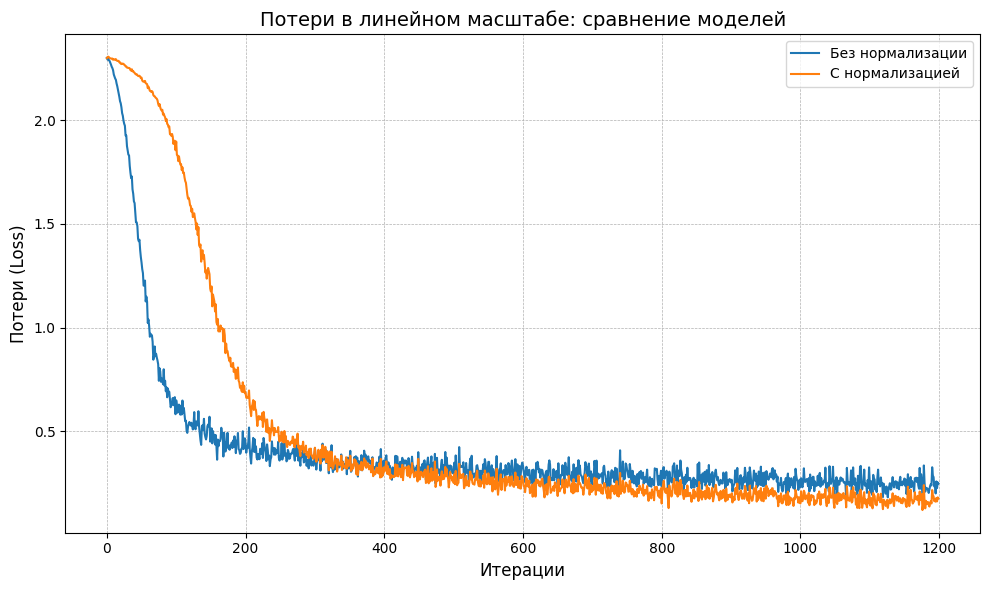

In [ ]:

loss_histories["Без нормализации"] = loss_without_norm
loss_histories["С нормализацией"] = loss_with_norm
# Построение графика потерь в линейном масштабе
plt.figure(figsize=(10, 6))

# Линии для каждой модели
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в линейном масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()

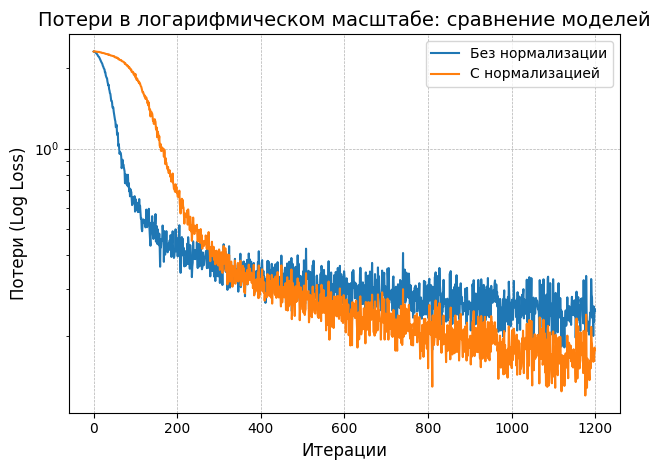

In [ ]:
# Линии для каждой модели
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

plt.yscale("log")

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Log Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в логарифмическом масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()

In [ ]:
#аналогично сделаем функцию для обучения с пом Adam
def train_model_adam(net, model_name):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    optimizer_state = {}

    # Конфигурация Adam
    optimizer_config = {
        'learning_rate': 1e-2,
        'beta1': 0.9,
        'beta2': 0.999,
        'epsilon': 1e-8
    }

    # Замер времени
    start_time = time.time()

    # Обучение
    for epoch in range(n_epoch):
        indices = np.arange(train_images.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = train_images[indices[start:end]]
            y_batch = train_labels_one_hot[indices[start:end]]

            # Сбрасываем градиенты
            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление параметров с использованием Adam
            adam_optimizer(net.getParameters(),
                           net.getGradParameters(),
                           optimizer_config,
                           optimizer_state)

            loss_history.append(loss)

        print(f"[{model_name}] Эпоха {epoch + 1}, текущая потеря: {loss:.4f}")

    # Замер времени
    execution_time = time.time() - start_time
    return loss_history, execution_time

In [ ]:
train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")
train_images = np.array(train_images).reshape(-1, 28 * 28) / 255.0
test_images = np.array(test_images).reshape(-1, 28 * 28) / 255.0

In [ ]:
n_epoch = 10
batch_size = 500
results = {}
execution_times = {}
# без BatchNormalization
net_without_norm_adam = Sequential()
net_without_norm_adam.add(Linear(28 * 28, 128))
net_without_norm_adam.add(ReLU())
net_without_norm_adam.add(Linear(128, 10))
net_without_norm_adam.add(LogSoftMax())
#  с BatchNormalization
net_with_norm_adam = Sequential()
net_with_norm_adam.add(Linear(28 * 28, 128))
batch_norm_00 = BatchNormalization(128)
batch_norm_00.alpha = 0.9
net_with_norm.add(batch_norm_00)
net_with_norm_adam.add(ChannelwiseScaling(128))
net_with_norm_adam.add(ReLU())
net_with_norm_adam.add(Linear(128, 10))
net_with_norm_adam.add(LogSoftMax())

In [ ]:
np.random.seed(42)
np.random.seed(42)
loss_adam_without_norm, time_adam_without_norm = train_model_adam(net_without_norm_adam, "Без нормаизации Adam")
np.random.seed(42)
loss_adam_with_norm, time_adam_with_norm = train_model_adam(net_with_norm_adam, "С нормализацией Adam")


[Без нормаизации Adam] Эпоха 1, текущая потеря: 0.1651
[Без нормаизации Adam] Эпоха 2, текущая потеря: 0.0938
[Без нормаизации Adam] Эпоха 3, текущая потеря: 0.0766
[Без нормаизации Adam] Эпоха 4, текущая потеря: 0.0595
[Без нормаизации Adam] Эпоха 5, текущая потеря: 0.0799
[Без нормаизации Adam] Эпоха 6, текущая потеря: 0.0346
[Без нормаизации Adam] Эпоха 7, текущая потеря: 0.0219
[Без нормаизации Adam] Эпоха 8, текущая потеря: 0.0218
[Без нормаизации Adam] Эпоха 9, текущая потеря: 0.0537
[Без нормаизации Adam] Эпоха 10, текущая потеря: 0.0236
[С нормализацией Adam] Эпоха 1, текущая потеря: 0.2350
[С нормализацией Adam] Эпоха 2, текущая потеря: 0.1343
[С нормализацией Adam] Эпоха 3, текущая потеря: 0.1113
[С нормализацией Adam] Эпоха 4, текущая потеря: 0.0755
[С нормализацией Adam] Эпоха 5, текущая потеря: 0.1140
[С нормализацией Adam] Эпоха 6, текущая потеря: 0.0700
[С нормализацией Adam] Эпоха 7, текущая потеря: 0.0349
[С нормализацией Adam] Эпоха 8, текущая потеря: 0.0605
[С нормал

In [ ]:
accuracy_without_norm_Adam = evaluate_model(net_without_norm_adam, "Без нормаизации Адам")
accuracy_with_norm_Adam = evaluate_model(net_with_norm_adam, "С нормализацией Адам")

In [ ]:

print("Результаты сравнения моделей:")

print("\nМодель: Без нормаизации")
print(f"Точность: {accuracy_without_norm:.4f}")
print(f"Время выполнения: {time_without_norm:.2f} секунд")

print("\nМодель: С нормализацией")
print(f"Точность: {accuracy_with_norm:.4f}")
print(f"Время выполнения: {time_with_norm:.2f} секунд")

print("\nМодель: Без нормаизации Адам")
print(f"Точность: {accuracy_without_norm_Adam:.4f}")
print(f"Время выполнения: {time_adam_without_norm:.2f} секунд")

print("\nМодель: С нормализацией Адам")
print(f"Точность: {accuracy_with_norm_Adam:.4f}")
print(f"Время выполнения: {time_adam_with_norm:.2f} секунд")

Результаты сравнения моделей:

Модель: Без нормаизации
Точность: 0.9327
Время выполнения: 311.03 секунд

Модель: С нормализацией
Точность: 0.9536
Время выполнения: 313.96 секунд

Модель: Без нормаизации Адам
Точность: 0.9730
Время выполнения: 310.92 секунд

Модель: С нормализацией Адам
Точность: 0.9705
Время выполнения: 311.34 секунд


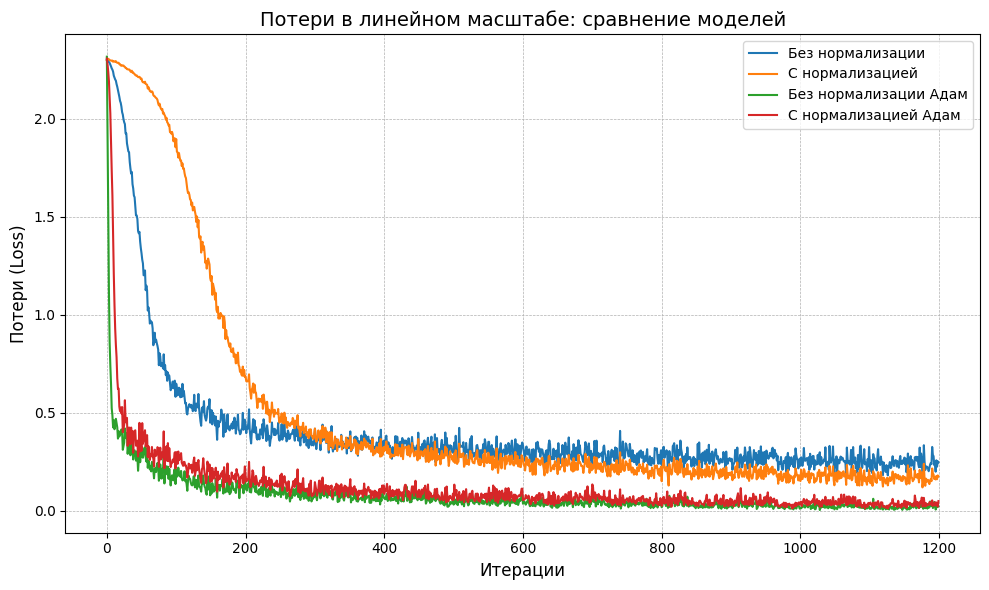

In [ ]:

loss_histories["Без нормализации Адам"] = loss_adam_without_norm
loss_histories["С нормализацией Адам"] = loss_adam_with_norm
# Построение графика потерь в линейном масштабе
plt.figure(figsize=(10, 6))

# Линии для каждой модели
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в линейном масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()

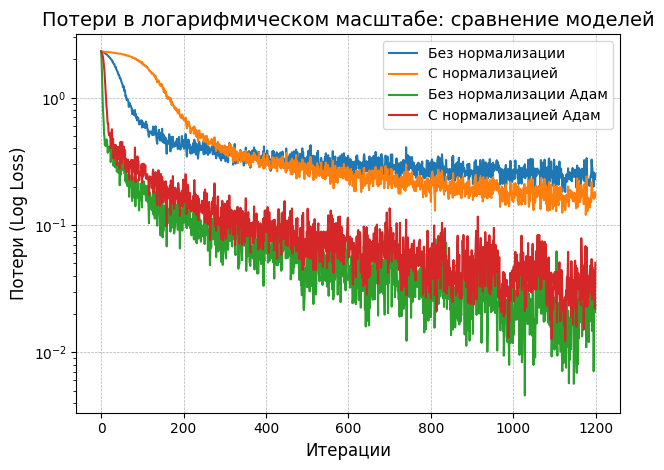

In [ ]:
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

plt.yscale("log")

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Log Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в логарифмическом масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Нормализация несколько уменьшила осцилляции, однако потребовала дополнительного времени на вычисления, вероятно, можно получить лучшие результаты по производительнсти для более глубоких сетей.
Нормализация увеличила точность для моели с SGD и практически не изменила для Адама, увеличилось и  время обучения, функция потерь также уменьшилась для SGD, и практически не поменялась для Адам.

Кажется, что использование батч нормализации не очень подходит для этой модели, особенно для Adam, поскольку она слишком простая. Однако оставим ее для следующей задачи (супермодель), поскольку там будет больше слоев.

В итоге, для задач с ограниченными вычислительными ресурсами, вероятно, я бы рекомендовал использовать ReLU, а для задач, где важна стабильность, — ELU или SoftPlus, во всех случаях кроме самых простых моделей считаю что нужно использвоать пакетную нормализацию, тк она позволяет уменьшить потери, сгладить функцию и, как мне кажется, увеличить скорость сходимости, несмотря на небольшие дополнительные временные затраты на вычисиления.

In [ ]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Сначала разберемся с аугументацией данных

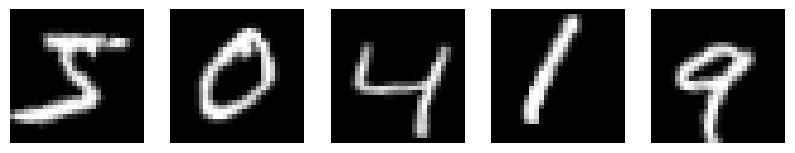

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

train_images_reshaped = np.array(train_images).reshape(-1, 28, 28, 1)
test_images = np.array(test_images).reshape(-1, 28 * 28) / 255.0

# Настраиваем генератор
datagen = ImageDataGenerator(
    rotation_range=15,          # Поворот на угол до 15 градусов
    width_shift_range=0.1,      # Сдвиг по ширине до 10%
    height_shift_range=0.1,     # Сдвиг по высоте до 10%
    zoom_range=0.1,             # Масштабирование до 10%
    fill_mode='nearest'         # Заполнение пустых пикселей
)

# Генерируем аугментированные данные и сохраняем их как numpy массивы
augmented_train_images = []
augmented_train_labels = []

# Применяем ауг сохраняем результаты
for x_batch, y_batch in datagen.flow(train_images_reshaped, train_labels, batch_size=500, shuffle=False):
    augmented_train_images.append(x_batch)
    augmented_train_labels.append(y_batch)
    if len(augmented_train_images) * 500 >= len(train_images):  # Ограничиваем размер как оригинальный набор
        break

# Объединяем ауг данные в один массив
augmented_train_images = np.concatenate(augmented_train_images, axis=0).reshape(-1, 28 * 28)  # Преобразуем в 2D формат
augmented_train_labels = np.concatenate(augmented_train_labels, axis=0).astype(int)  # Приводим к int

# Создаем one-hot encoding для аугх меток
train_labels_one_hot = np.eye(num_classes)[augmented_train_labels]

# Нормализуем изображения
train_images = augmented_train_images / 255.0


# Визуализируем пример аугментации
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

построим суперсеть

In [ ]:
# Your code goes here. ################################################
super_net = Sequential()
super_net.add(Linear(28 * 28, 128))
super_net.add(ReLU())
super_net.add(Dropout(0.1))
super_net.add(Linear(128, 64))
batch_norm_2 = BatchNormalization(64)
batch_norm_2.alpha = 0.9
super_net.add(batch_norm_2)
super_net.add(ChannelwiseScaling(64))
super_net.add(ReLU())
super_net.add(Linear(64, 10))
super_net.add(LogSoftMax())


In [ ]:
#аналогично сделаем функцию для обучения с лернинг рейт декей
def train_model_super(net, model_name, lr, decay_rate):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    optimizer_state = {}

    # Конфигурация Adam
    optimizer_config = {
        'learning_rate': lr,
        'beta1': 0.9,
        'beta2': 0.999,
        'epsilon': 1e-8
    }

    # Замер времени
    start_time = time.time()

    # Обучение
    for epoch in range(n_epoch):
        if epoch > 0:
          lr *= decay_rate
        indices = np.arange(train_images.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = train_images[indices[start:end]]
            y_batch = train_labels_one_hot[indices[start:end]]

            # Сбрасываем градиенты
            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление параметров с использованием Adam
            adam_optimizer(net.getParameters(),
                           net.getGradParameters(),
                           optimizer_config,
                           optimizer_state)

            loss_history.append(loss)

        print(f"[{model_name}] Эпоха {epoch + 1}, текущая потеря: {loss:.4f}, Learning Rate: {lr:.6f}")

    # Замер времени
    execution_time = time.time() - start_time
    return loss_history, execution_time

In [ ]:
np.random.seed(42)
loss_super_with_norm, time_super_with_norm = train_model_super(super_net, "Суперпупер сеть", 0.001, 0.95)




[Суперпупер сеть] Эпоха 1, текущая потеря: 1.1715, Learning Rate: 0.001000
[Суперпупер сеть] Эпоха 2, текущая потеря: 0.4125, Learning Rate: 0.000950
[Суперпупер сеть] Эпоха 3, текущая потеря: 0.2504, Learning Rate: 0.000902
[Суперпупер сеть] Эпоха 4, текущая потеря: 0.1906, Learning Rate: 0.000857
[Суперпупер сеть] Эпоха 5, текущая потеря: 0.1870, Learning Rate: 0.000815
[Суперпупер сеть] Эпоха 6, текущая потеря: 0.1752, Learning Rate: 0.000774
[Суперпупер сеть] Эпоха 7, текущая потеря: 0.1826, Learning Rate: 0.000735
[Суперпупер сеть] Эпоха 8, текущая потеря: 0.1365, Learning Rate: 0.000698
[Суперпупер сеть] Эпоха 9, текущая потеря: 0.1430, Learning Rate: 0.000663
[Суперпупер сеть] Эпоха 10, текущая потеря: 0.1055, Learning Rate: 0.000630


In [ ]:
accuracy_with_norm_super = evaluate_model(super_net, "Суперпупер сеть")

print("\nМодель: суперсетка")
print(f"Точность: {accuracy_with_norm_super:.4f}")
print(f"Время выполнения: {time_super_with_norm:.2f} секунд")


Модель: суперсетка
Точность: 0.9731
Время выполнения: 358.51 секунд


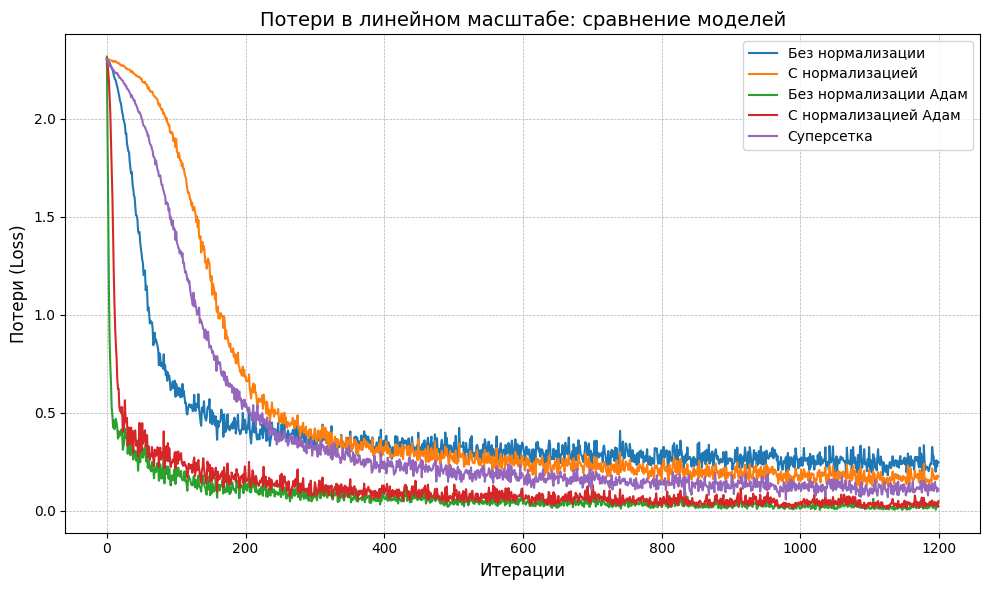

In [ ]:
loss_histories["Суперсетка"] = loss_super_with_norm
del loss_histories["суперсетка PyTorch"]
# Построение графика потерь в линейном масштабе
plt.figure(figsize=(10, 6))

# Линии для каждой модели
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в линейном масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()

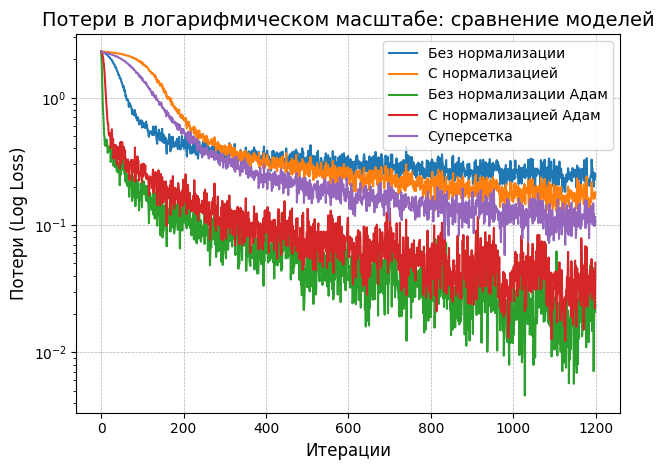

In [ ]:
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

plt.yscale("log")

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Log Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в логарифмическом масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
#pip install --upgrade sympy

In [ ]:
def evaluate_model_pytorch(net, test_loader):
    net.eval()  # Устанавливаем модель в режим тестирования
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch_images, batch_labels in test_loader:
            outputs = net(batch_images)  # Прямой проход
            _, predicted = torch.max(outputs, 1)  # Индекс максимального значения (класс)
            total += batch_labels.size(0)  # Общее количество объектов
            correct += (predicted == batch_labels).sum().item()  # Сравнение предсказанных и реальных меток

    accuracy = correct / total  # Расчёт точности
    return accuracy

In [ ]:
# Your beautiful code here.
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Подготовка данных
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

batch_size = 500

# Создание DataLoader для загрузки данных батчами
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определяем архитектуру PyTorch-суперсети
class PT_SuperNet(nn.Module):
    def __init__(self):
        super(PT_SuperNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        #self.batch_norm1 = nn.BatchNorm1d(128, momentum=0.9)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64, momentum=0.9)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.log_softmax(x)
        return x

# Функция для обучения модели с Learning Rate Decay
def train_model_pt_super(model, train_loader, criterion, optimizer, n_epochs, initial_lr, decay_rate):
    loss_history = []
    start_time = time.time()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)  # Экспоненциальное уменьшение LR
    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch_images, batch_labels in train_loader:
            optimizer.zero_grad()  # Сброс градиентов
            outputs = model(batch_images)  # Прямой проход
            loss = criterion(outputs, batch_labels)  # Вычисление потерь
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновление параметров
            epoch_loss += loss.item()
            loss_history.append(loss.item())

        scheduler.step()  # Обновление Learning Rate
        current_lr = scheduler.get_last_lr()[0]
        print(f"Эпоха {epoch+1}/{n_epochs}, Потери: {epoch_loss / len(train_loader):.4f}, Learning Rate: {current_lr:.6f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

# Инициализация PT-суперсети
pt_super_net = PT_SuperNet()
criterion = nn.NLLLoss()  # Критерий потерь
optimizer = optim.Adam(pt_super_net.parameters(), lr=0.001)

# Обучение модели
loss_pt_super_net, execution_time_pt_super_net = train_model_pt_super(pt_super_net, train_loader, criterion, optimizer, n_epochs=10, initial_lr=0.001, decay_rate=0.95)

accuracy_PyTorch = evaluate_model_pytorch(pt_super_net, test_loader)

print("\nМодель: суперсетка PyTorch")
print(f"Точность: {accuracy_PyTorch:.4f}")
print(f"Время выполнения: {execution_time_pt_super_net:.2f} секунд")

Эпоха 1/10, Потери: 0.9736, Learning Rate: 0.000950
Эпоха 2/10, Потери: 0.3402, Learning Rate: 0.000902
Эпоха 3/10, Потери: 0.2375, Learning Rate: 0.000857
Эпоха 4/10, Потери: 0.1947, Learning Rate: 0.000815
Эпоха 5/10, Потери: 0.1644, Learning Rate: 0.000774
Эпоха 6/10, Потери: 0.1458, Learning Rate: 0.000735
Эпоха 7/10, Потери: 0.1320, Learning Rate: 0.000698
Эпоха 8/10, Потери: 0.1218, Learning Rate: 0.000663
Эпоха 9/10, Потери: 0.1114, Learning Rate: 0.000630
Эпоха 10/10, Потери: 0.1022, Learning Rate: 0.000599

Модель: суперсетка PyTorch
Точность: 0.9707
Время выполнения: 17.82 секунд


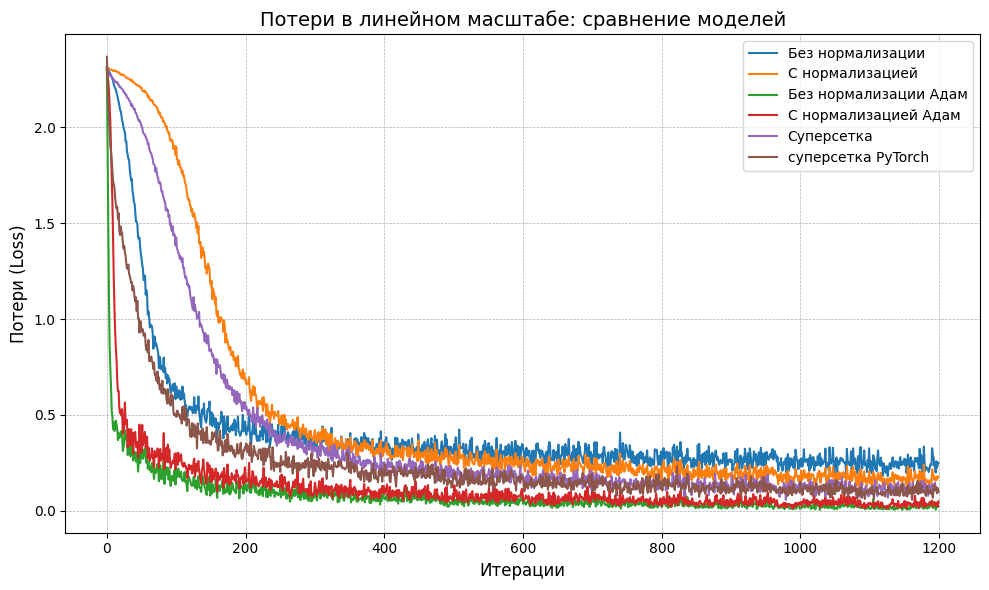

In [ ]:
loss_histories["суперсетка PyTorch"] = loss_pt_super_net
# Построение графика потерь в линейном масштабе
plt.figure(figsize=(10, 6))

# Линии для каждой модели
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в линейном масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()

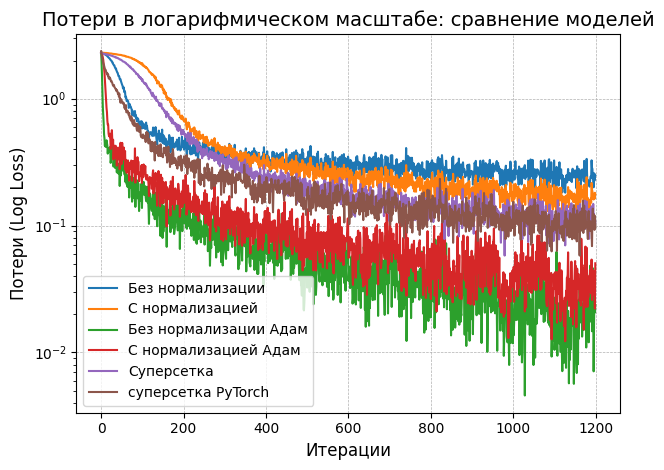

In [ ]:
for model_name, history in loss_histories.items():
    plt.plot(history, label=model_name)

plt.yscale("log")

# Подписываем оси
plt.xlabel("Итерации", fontsize=12)
plt.ylabel("Потери (Log Loss)", fontsize=12)

# Заголовок и легенда
plt.title("Потери в логарифмическом масштабе: сравнение моделей", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Показ графика
plt.tight_layout()
plt.show()


##общие выводы
- Модели, обученные с Adam, демонстрируют быстрее снижающиеся потери и достигают более высокой точности
- Пайторч суперсетка показывает практически аналогичную точность по сравнению с исходной реализацией, но вермя вычисления слегка меньше)))
- Суперсетка получилась более точной, чем другие модели
